<a href="https://colab.research.google.com/github/Ryu4824/code-states/blob/main/n232_discussion_9%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **N232 Interpretable ML - II**

## 오늘의 목표
- ICE plot 및 PDP에 대해 이해하고 설명할 수 있습니다. 
- pdpbox 라이브러리를 사용하여 모델 학습 결과를 PDP로 나타내고 해석할 수 있습니다. 

## **개념 Topic**
> 오늘은 ICE plot 및 PDP에 대해 배웠습니다.

- PDP 해석 시 유의할 점을 설명해 보세요. 
  - 가능하다면 구체적인 예시를 들어 설명해보세요.
  - 만약 설명이 어렵다면 어느 부분이 이해가 안 되는지 구체적인 질문을 동기들과 나눠보세요.
- PDP 해석 시 유의점
  - PDP는 각 변수 간의 독립성을 전제로 한다.
    - 서로 강한 상관관계가 있는 경우 비현실적인 데이터를 입력값으로 사용
      - 17세 대학원 졸업 학력
      - 키가 60cm인데 몸무게가 80kg인 경우 (전인구 대상 설문조사)
  - PDP를 해석할 때 살펴보고자 하는 변수의 분포를 확인해야 한다.
    - 모델이 학습 과정에서 해당 변수값을 갖는 데이터를 학습하지 못했다면, 모델은 해당 구간에서 이상한 예측값을 낼 수 있다.
- **Discussion** 표의 `정리` 탭에 답변을 정리하여 적어 주세요. 

## **코딩 Topic**

### **Part.1 : 데이터 준비**

중고차 가격 예측 데이터셋인 [100,000 UK Used Car Data set](https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes)을 사용해서 회귀 문제를 풀어보겠습니다. 

> **Data Description**

- company : car manufacturer
- model : car model
- year : registration year
- transmission : type of gearbox
- mileage : distance used
- fuelType : engine fuel
- tax : road tax
- mpg : miles per gallon
- engineSize : size in litres
- price : price in £

In [ ]:
# 실행하고 런타임 재시작
!pip install category_encoders
!pip install pdpbox
!pip install xgboost==1.7.2

In [ ]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.pipeline import *
from category_encoders import *
from sklearn.impute import *
from sklearn.tree import *
from xgboost import *
from pdpbox.pdp import *

import warnings
warnings.filterwarnings('ignore')

#### **1-1. 데이터셋 불러오기 및 전처리**
- 데이터셋을 불러오세요. 
- 자유롭게 EDA 및 전처리를 수행해 보세요.

In [ ]:
# 데이터 분러오기
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/renewal/mldl/used_car.csv')
df.head()

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vauxhall,Corsa,2018,Manual,9876,Petrol,145,55.4,1.4,7885
1,vauxhall,Corsa,2019,Manual,2500,Petrol,145,54.3,1.4,11995
2,vauxhall,Corsa,2017,Automatic,9625,Petrol,145,47.9,1.4,9777
3,vauxhall,Corsa,2016,Manual,25796,Petrol,30,55.4,1.4,8500
4,vauxhall,Corsa,2019,Manual,3887,Petrol,145,43.5,1.4,10000


In [ ]:
# 결측치 및 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97712 entries, 0 to 97711
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       97712 non-null  object 
 1   model         97712 non-null  object 
 2   year          97712 non-null  int64  
 3   transmission  97712 non-null  object 
 4   mileage       97712 non-null  int64  
 5   fuelType      97712 non-null  object 
 6   tax           97712 non-null  int64  
 7   mpg           97712 non-null  float64
 8   engineSize    97712 non-null  float64
 9   price         97712 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 7.5+ MB


In [ ]:
# 데이터 이상치 확인
df[df.year > 2023]

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
73651,ford,Fiesta,2060,Automatic,54807,Petrol,205,42.8,1.4,6495


In [ ]:
# 데이터 이상치 대체
df.year = df.year.replace({2060:2016})
df[df.year >2023]

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price


In [ ]:
# 중복값 확인
df[df.duplicated()]

,company,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price


#### **1-2. 데이터셋 분리**
- 특성 X와 타겟 y를 지정하세요.
  - 타겟은 `price`입니다. 
- X와 y 모두 train/test set으로 분리하세요.
  - 적절한 비로 train : test 비를 설정하세요.
  - `random_state`로 시드를 고정하세요.
- X와 y 모두 train set을 train/validation set으로 분리하세요. 
  - 적절한 비로 train : val 비를 설정하세요.
  - `random_state`로 시드를 고정하세요.

In [ ]:
# 특성과 타겟 지정
target = 'price'

X = df.drop(target, axis=1)
y = df[target]

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

### **Part.2 : Modeling**

#### **2-1. 기준모델**
- 평균을 이용하여 기준모델을 만들고, MAE 또는 RMSE 값을 확인하세요. 
  - 기준모델은 train set에 대하여 생성합니다. 

In [ ]:
# 기준모델
base = [y_train.mean()] * len(y_train)

print('기준 모델의 MAE : ', mean_absolute_error(y_train, base))

기준 모델의 MAE :  7068.480482929304


#### **2-2. 모델 학습**
- 범주형 변수는 적절한 encoding을 사용하여 변환하세요. 
- 회귀 트리 모델을 사용하여 학습하세요. 
    - 회귀 트리 모델에는 `DecisionTreeRegressor()`, `RandomForestRegressor()`, `XGBRegressor()` 등이 있습니다. 
    - `random_state`로 시드를 고정하세요.
- train/val set의 MAE(또는 RMSE)와 $R^2$ score를 각각 구하세요.  

In [ ]:
# 범주형 변수 분리
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['company', 'model', 'transmission', 'fuelType']

In [ ]:
# DecisionTree Regressor
pipe_dt = make_pipeline(
    OrdinalEncoder(cols = cat_cols),
    DecisionTreeRegressor(
        max_depth = 5,
        random_state=42
    )
)

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['company', 'model', 'transmission',
                                      'fuelType'],
                                mapping=[{'col': 'company',
                                          'data_type': dtype('O'),
                                          'mapping': ford        1
vw          2
bmw         3
toyota      4
vauxhall    5
skoda       6
audi        7
merc        8
hyundi      9
NaN        -2
dtype: int64},
                                         {'col': 'model',
                                          'data_type': dtype('O'),
                                          'mapping':  Fiesta       1
 Touran       2
 Passat       3
 Kuga         4
 T-Cross      5
           ... 
 Ranger     185
 A2         186
 Amica      187
 RS7        188
NaN          -2
Length: 189, dtype: int64},
                                         {'col': 'transmission',
                                          'data_type': dtype('O'),
                                          'mapping': Manual       1
Semi-Auto    2
Automatic    3
Other        4
NaN         -2
dtype: int64},
                                         {'col': 'fuelType',
                                          'data_type': dtype('O'),
                                          'mapping': Petrol      1
Diesel      2
Hybrid      3
Other       4
Electric    5
NaN        -2
dtype: int64}])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [ ]:
# RandomForest Regressor의 성능

pred_train_dt = pipe_dt.predict(X_train)
pred_val_dt = pipe_dt.predict(X_val)

print('DT 모델의 훈련 세트 MAE : ', mean_absolute_error(y_train, pred_train_dt).round(2))
print('DT 모델의 검증 세트 MAE : ', mean_absolute_error(y_val, pred_val_dt).round(2))
print('DT 모델의 훈련 세트 R2 Score : ', r2_score(y_train, pred_train_dt))
print('DT 모델의 검증 세트 R2 Score : ', r2_score(y_val, pred_val_dt))

DT 모델의 훈련 세트 MAE :  2999.01
DT 모델의 검증 세트 MAE :  3036.18
DT 모델의 훈련 세트 R2 Score :  0.8004287586081429
DT 모델의 검증 세트 R2 Score :  0.8002860953640246


In [ ]:
# RandomForest Regressor
pipe_rf = make_pipeline(
    OrdinalEncoder(cols = cat_cols),
    RandomForestRegressor(
        n_estimators = 100,
        max_depth = 5,
        n_jobs = -1,
        random_state = 42
    )
)

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['company', 'model', 'transmission',
                                      'fuelType'],
                                mapping=[{'col': 'company',
                                          'data_type': dtype('O'),
                                          'mapping': ford        1
vw          2
bmw         3
toyota      4
vauxhall    5
skoda       6
audi        7
merc        8
hyundi      9
NaN        -2
dtype: int64},
                                         {'col': 'model',
                                          'data_type': dtype('O'),
                                          'mapping':  Fiesta       1
 Touran       2
 Passat       3
 Kuga         4
 T-Cross      5
           ... 
 Ranger     185
 A2         186
 Amica      187
 RS7        188
NaN          -2
Length: 189, dtype: int64},
                                         {'col': 'transmission',
                                          'data_type': dtype('O'),
                                          'mapping': Manual       1
Semi-Auto    2
Automatic    3
Other        4
NaN         -2
dtype: int64},
                                         {'col': 'fuelType',
                                          'data_type': dtype('O'),
                                          'mapping': Petrol      1
Diesel      2
Hybrid      3
Other       4
Electric    5
NaN        -2
dtype: int64}])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_jobs=-1,
                                       random_state=42))])

In [ ]:
# RandomForest Regressor의 성능

pred_train_rf = pipe_rf.predict(X_train)
pred_val_rf = pipe_rf.predict(X_val)

print('RF 모델의 훈련 세트 MAE : ', mean_absolute_error(y_train, pred_train_rf).round(2))
print('RF 모델의 검증 세트 MAE : ', mean_absolute_error(y_val, pred_val_rf).round(2))
print('RF 모델의 훈련 세트 R2 Score : ', r2_score(y_train, pred_train_rf))
print('RF 모델의 검증 세트 R2 Score : ', r2_score(y_val, pred_val_rf))

RF 모델의 훈련 세트 MAE :  2920.91
RF 모델의 검증 세트 MAE :  2959.54
RF 모델의 훈련 세트 R2 Score :  0.8139332687359822
RF 모델의 검증 세트 R2 Score :  0.8114648852542015


In [ ]:
# XGBoost Regressor
pipe_xgb = make_pipeline(
    OrdinalEncoder(cols = cat_cols),
    XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=5,
        learning_rate=0.1
    )
)

pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['company', 'model', 'transmission',
                                      'fuelType'],
                                mapping=[{'col': 'company',
                                          'data_type': dtype('O'),
                                          'mapping': ford        1
vw          2
bmw         3
toyota      4
vauxhall    5
skoda       6
audi        7
merc        8
hyundi      9
NaN        -2
dtype: int64},
                                         {'col': 'model',
                                          'data_type': dtype('O'),
                                          'mapping':  Fiesta       1
 Touran       2
 Passat       3
 Kuga         4
 T-Cross      5
           ... 
 Ranger     185
 A2         186
 Amica      187
 RS7        188
NaN          -2
Leng...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
                              predictor='auto', random_state=42, ...))])

In [ ]:
# XGBoost Regressor의 성능

pred_train_xgb = pipe_xgb.predict(X_train)
pred_val_xgb = pipe_xgb.predict(X_val)

print('XGBoost 모델의 훈련 세트 MAE : ', mean_absolute_error(y_train, pred_train_xgb))
print('XGBoost 모델의 검증 세트 MAE : ', mean_absolute_error(y_val, pred_val_xgb))
print('XGBoost 모델의 훈련 세트 R2 Score : ', r2_score(y_train, pred_train_xgb))
print('XGBoost 모델의 검증 세트 R2 Score : ', r2_score(y_val, pred_val_xgb))

XGBoost 모델의 훈련 세트 MAE :  1556.2485553317192
XGBoost 모델의 검증 세트 MAE :  1625.314181785198
XGBoost 모델의 훈련 세트 R2 Score :  0.9441568106313316
XGBoost 모델의 검증 세트 R2 Score :  0.9353264347761874


#### **2-3. 과적합 해소(optional)**
- 과적합을 해소하기 위한 다양한 시도를 해 보세요. 
  - early stopping
  - 하이퍼파라미터 튜닝
- 과적합이 발생하지 않았다.

### **Part.3 모델 해석**
- 성능이 가장 좋았던 xgb 모델로 수행

#### **3-1. 1특성 PDP**
- 최소 2가지 특성에 대해 PDP를 해석해 보세요. 

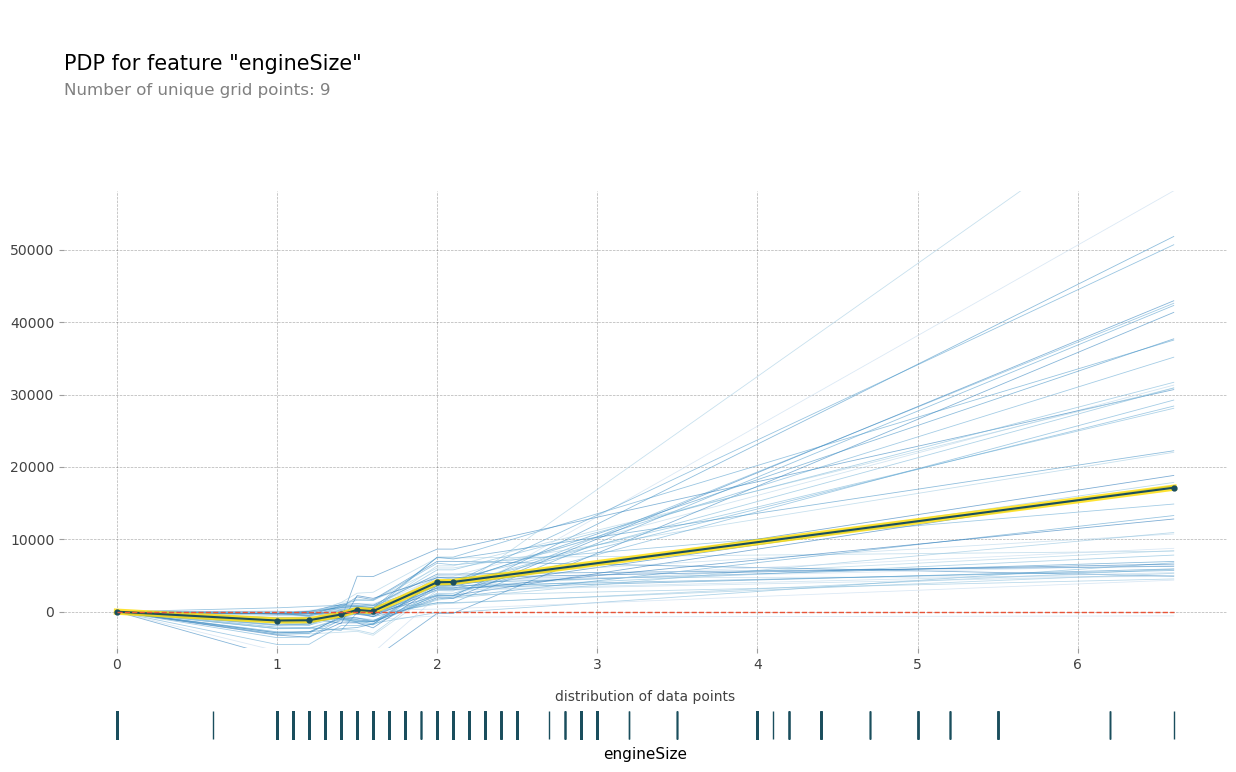

In [ ]:
# engineSize (연속)

target_feature = 'engineSize'

isolated = pdp_isolate(
    model=pipe_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50, 
    plot_pts_dist=True,
)

plt.show()

`engineSize` 변수에 대한 해석
- engineSize가 커질수록 Price 또한 상승하는 모습을 보여준다.

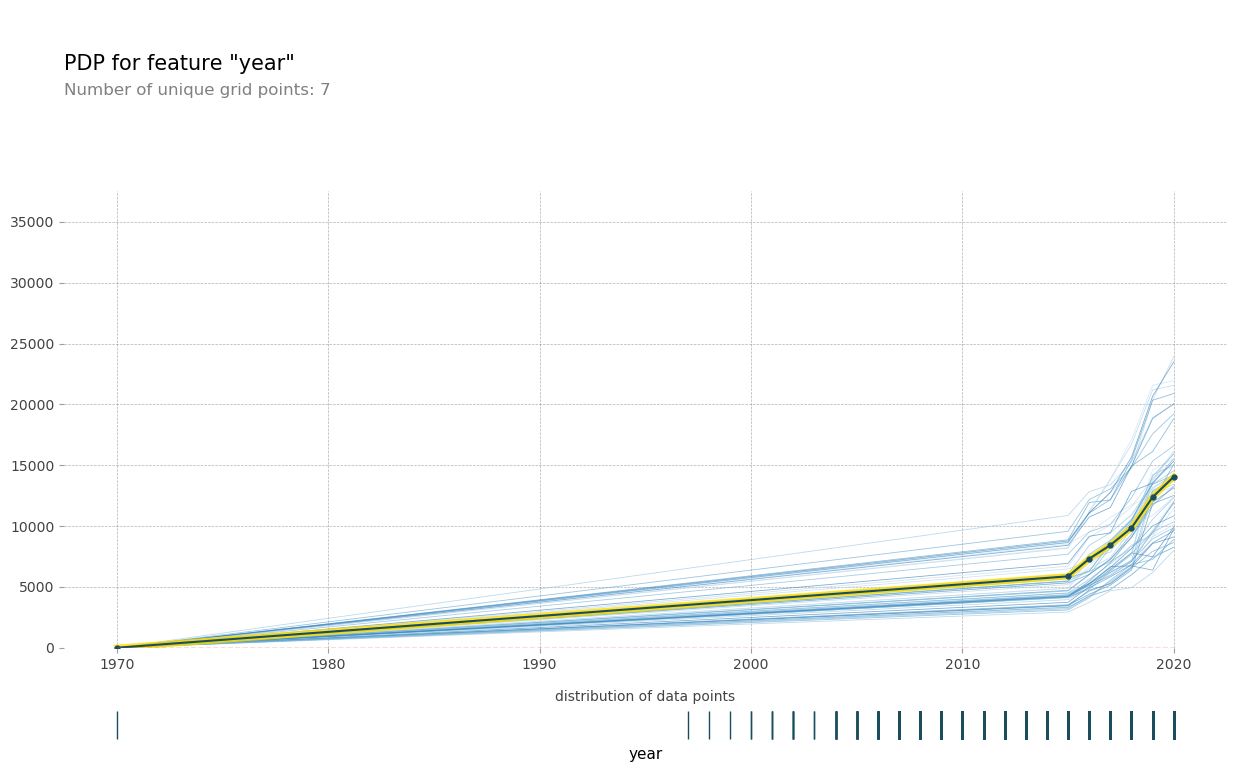

In [ ]:
# year (연속)

target_feature = 'year'

isolated = pdp_isolate(
    model=pipe_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50, 
    plot_pts_dist=True,
)

plt.show()

`year` 변수에 대한 해석
- year 수치가 오를수록 price가 오르는 경향이 있다.
- year 수치가 2000년대 전인 데이터는 적게 존재한다.
- 2015년을 기점으로 year에 따른 price의 증가량이 두드러지게 나타난다.

In [ ]:
cat_cols

['company', 'model', 'transmission', 'fuelType']

In [ ]:
# 범주형 PDP 보기 위한 준비 과정
encoder = OrdinalEncoder(cols = cat_cols)
X_train_encoded = encoder.fit_transform(X_train)  # 학습데이터
X_val_encoded = encoder.transform(X_val)  # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

In [ ]:
target_feature = 'model'

mappings = encoder.mapping
mapping_data = list(filter(lambda x: x["col"] == target_feature, mappings))
print(mapping_data)

[{'col': 'model', 'mapping':  Fiesta       1
 Touran       2
 Passat       3
 Kuga         4
 T-Cross      5
           ... 
 Ranger     185
 A2         186
 Amica      187
 RS7        188
NaN          -2
Length: 189, dtype: int64, 'data_type': dtype('O')}]


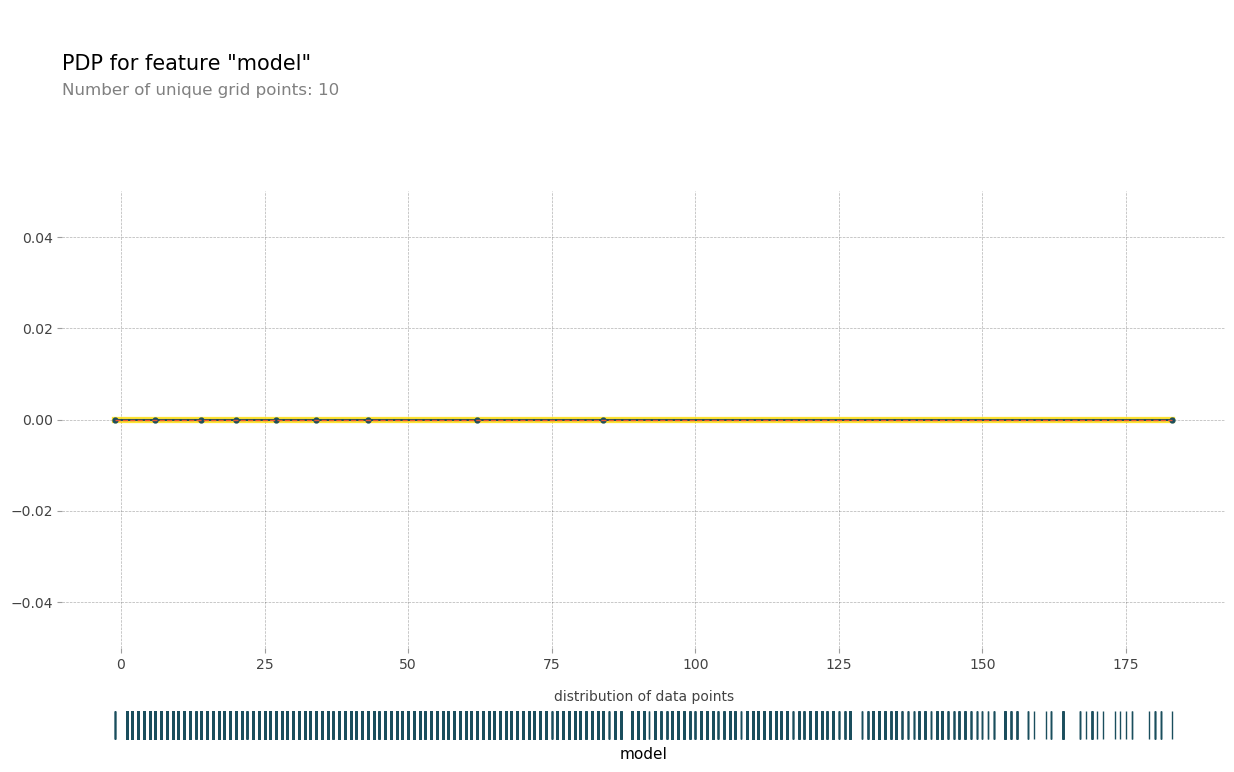

In [ ]:
# model (범주)
target_feature = 'model'

isolated = pdp_isolate(
    model=pipe_xgb,
    dataset=X_test_encoded,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50, 
    plot_pts_dist=True,
)
plt.show()

In [ ]:
# 그림이 이상해서 pipeline이 아닌 직접 모델링 수행
xgb_c = XGBRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=5,
        learning_rate=0.1
      )

xgb_c.fit(X_train_encoded, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

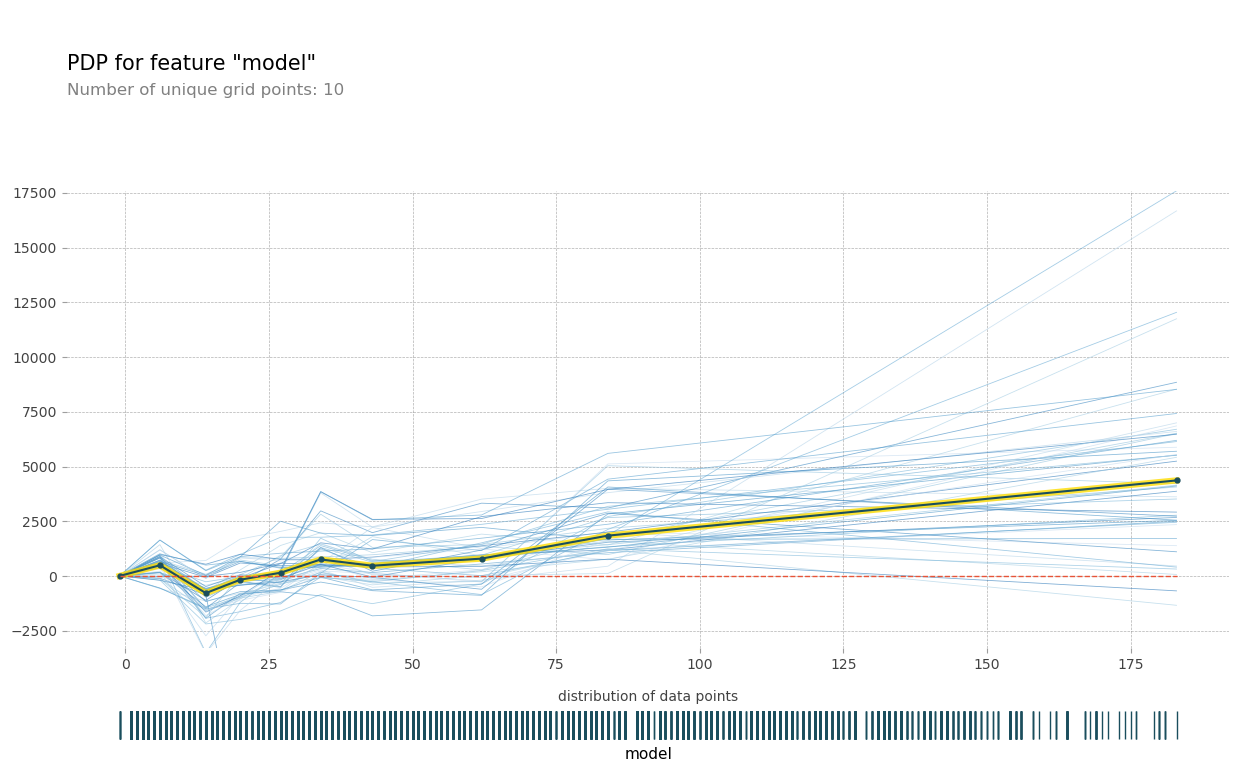

In [ ]:
target_feature = 'model'

isolated = pdp_isolate(
    model=xgb_c,
    dataset=X_test_encoded,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type="percentile",
    num_grid_points=10, 
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50, 
    plot_pts_dist=True,
)
plt.show()

`model` 해석
- 그래프에 따르면 OrdinalEncoding 후 그 수치가 높은 모델 타입이 price가 높게 나타난다.
- 범주형 변수에 대해서 이러한 경향성이 나타난 것이 약간 의문이다.
  - 우연의 일치인지
  - OrdinalEncoding 시 저게 반영된 것인지

#### **3-2. 2특성 PDP**
- 자유롭게 특성을 선택하여 2특성 PDP를 해석해 보세요. 

In [ ]:
# engineSize, Year

target_features = ["engineSize", "year"]

interaction = pdp_interact(
    model=pipe_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=target_features
)

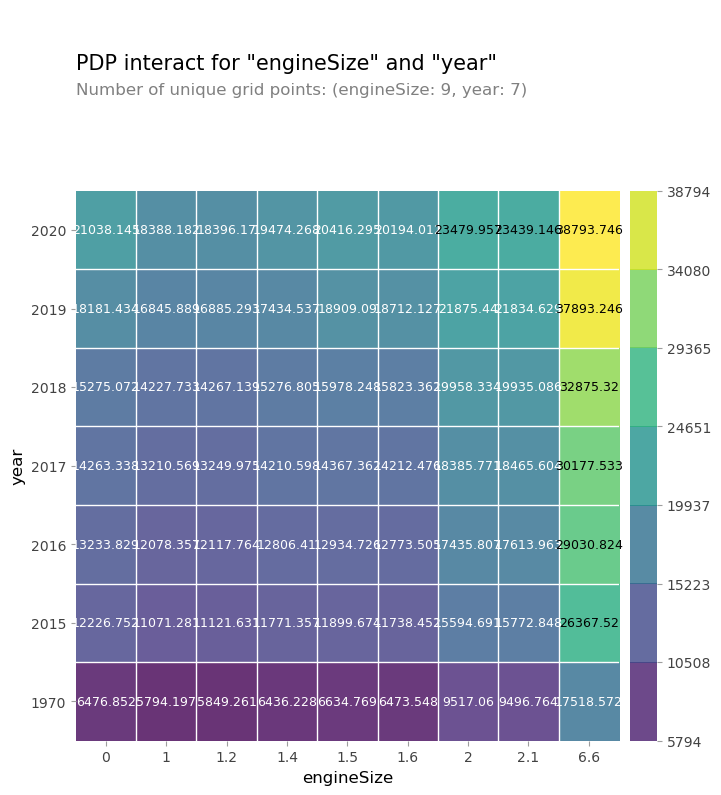

In [ ]:
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)
plt.show()

In [ ]:
interaction.pdp.query('engineSize == 6.6').sort_values('preds', ascending= False)

,engineSize,year,preds
62,6.6,2020.0,38793.746094
61,6.6,2019.0,37893.250000
60,6.6,2018.0,32875.320312
59,6.6,2017.0,30177.533203
58,6.6,2016.0,29030.824219
57,6.6,2015.0,26367.519531
56,6.6,1970.0,17518.572266


`engineSize`와 `Year` 해석
- 두 특성이 모두 높은 경우, price값이 높게 예측되었다.
- 이는 각 특성을 개별로 PDP한 결과와 동일한 모습을 보인다.

### **Conclusion**
> 오늘 Topic을 수행한 결과를 바탕으로, 다음 사항에 대해 답해 주세요.

1. 최소 2가지 특성에 대하여 1특성 PDP를 해석해 보세요.
- `engineSize` 변수에 대한 해석
  - engineSize가 커질수록 Price 또한 상승하는 모습을 보여준다.
- `year` 변수에 대한 해석
  - year 수치가 오를수록 price가 오르는 경향이 있다.
  - year 수치가 2000년대 전인 데이터는 적게 존재한다.
  - 2015년을 기점으로 year에 따른 price의 증가량이 두드러지게 나타난다.
`model` 해석
  - 그래프에 따르면 OrdinalEncoding 후 그 수치가 높은 모델 타입이 price가 높게 나타난다.
  - 범주형 변수에 대해서 이러한 경향성이 나타난 것이 약간 의문이다.
    - 우연의 일치인지
    - OrdinalEncoding 시 저게 반영된 것인지
2. 2특성 PDP를 해석해 보세요. 
- `engineSize`와 `Year` 해석
  - 두 특성이 모두 높은 경우, price값이 높게 예측되었다.
  - 이는 각 특성을 개별로 PDP한 결과와 동일한 모습을 보인다.
- **Discussion** 표의 `정리` 탭에 답변을 정리하여 적어 주세요. 

## **심화 Topic(optional)**
- ICE Plot과 PDP Plot의 특징에 대해 논의하고 언제 어떤 방법을 쓸 수 있을지 구체적인 예시를 들어 이야기해보세요.
  - ICE Plot
    - 특정 데이터에 대해서 특정 변수가 예측값에 미치는 영향을 시각화하여 해석하기 한다.
    - 일반적인 상황을 예측하기는 어렵지만, 특성 간의 상관관계를 파악하거나 모델의 비정상적인 예측 패턴 등을 파악하기 좋다.
  - PDP 
    - 전체 데이터의 평균을 이용하기 때문에 틀에서 특정 변수가 예측값에 미치는 영향을 쉽게 시각화하여 해석할 수 있다.
    - 특성 간 상관관계가 강할 경우 해석이 틀릴 수 있다.
- 여러분들이 프로젝트에서 모델을 만들고 모델 해석을 한다면 어떻게 사용할 수 있을까요?